# 1.1 ArchR process scATAC-seq data

Usually the scATAC-seq data is provided in the format of 'fragments.tsv'. In tmhis tutorial we showed the users how to utilize ArchR to process fragment files into a cell-by-peak matrix. The cell-by-peak matrix will be the input of CellOracle to generate the base GRN.  

The details of usage of ArchR can be refered at https://www.archrproject.com/articles/Articles/tutorial.html. 

If you have already got the cell-by-peak matrix, you can directly skip to 1.2 to generate the base GRN.

## import packages

In [5]:
library(ArchR)
set.seed(1)
library(parallel)

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats

## load fragment files & create arrow files

In [1]:
# - initial the ArchR folder to save temporary files
prefix = 'ArchR_files'
dir_ = paste0('./',prefix)
dir.create(dir_, recursive=T)
setwd(dir=dir_)

In [5]:
# - load the fragment files
inputFiles=c(
    'day00' = '/nfs/public/lichen/data/single_cell/reprogramming_case/fib_ipsc/ATAC/fastq/6231STDY9258270/Day00/outs/fragments.tsv.gz',
    'day14' = '/nfs/public/lichen/data/single_cell/reprogramming_case/fib_ipsc/ATAC/fastq/6231STDY9258270/Day14/outs/fragments.tsv.gz'
)

addArchRGenome("hg38") # be aware of the species version of refrence genome
# addArchRGenome("hg19") 
# addArchRGenome("mm10") 
# addArchRGenome("mm9") 

addArchRThreads(threads = 16) 
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  minTSS = 4, #Dont set this too high because you can always increase later
  minFrags = 1000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

Setting default genome to Hg38.

Setting default number of Parallel threads to 16.

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-1cdb03743a2877-Date-2023-09-20_Time-18-46-04.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2023-09-20 18:46:04 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-1cdb03743a2877-Date-2023-09-20_Time-18-46-04.log



In [6]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    LSIMethod = 1
)

proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = prefix,
  copyArrows = TRUE #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-1cdb0332496e6f-Date-2023-09-20_Time-18-59-37.log
If there is an issue, please report to github with logFile!

2023-09-20 18:59:37 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-09-20 18:59:37 : day14 (1 of 2) :  Computing Doublet Statistics, 0.001 mins elapsed.

day14 (1 of 2) : UMAP Projection R^2 = 0.97165

day14 (1 of 2) : UMAP Projection R^2 = 0.97165

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-09-20 19:03:17 : day00 (2 of 2) :  Computing Doublet Statistics, 3.674 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

day00 (2 of 2) : UMAP Projection R^2 = 0.95947

day00 (2 of 2) : UMAP Projection R^2 = 0.95947

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-1cdb

In [7]:
proj <- filterDoublets(ArchRProj = proj)

Filtering 1053 cells from ArchRProject!

	day14 : 636 of 7975 (8%)

	day00 : 417 of 6465 (6.5%)



## Clustering & UMAP plotting

In [8]:
# call peak and save peak matrix

pathToMacs2='/data1/lichen/anaconda3/envs/R4.0.2/bin/macs2' # replace this with your own directory path

proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI",
                       varFeatures = 50000,iteration=4,force = TRUE)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-1cdb036a6fa807-Date-2023-09-20_Time-19-09-48.log
If there is an issue, please report to github with logFile!

2023-09-20 19:09:49 : Computing Total Across All Features, 0.009 mins elapsed.

2023-09-20 19:09:51 : Computing Top Features, 0.055 mins elapsed.

###########
2023-09-20 19:09:53 : Running LSI (1 of 4) on Top Features, 0.086 mins elapsed.
###########

2023-09-20 19:09:53 : Sampling Cells (N = 10001) for Estimated LSI, 0.087 mins elapsed.

2023-09-20 19:09:53 : Creating Sampled Partial Matrix, 0.087 mins elapsed.

2023-09-20 19:10:33 : Computing Estimated LSI (projectAll = FALSE), 0.75 mins elapsed.

2023-09-20 19:11:13 : Identifying Clusters, 1.421 mins elapsed.

2023-09-20 19:11:30 : Identified 6 Clusters, 1.694 mins elapsed.

2023-09-20 19:11:30 : Saving LSI Iteration, 1.694 mins elapsed.

2023-09-20 19:11:49 : Creating Cluster Matrix on the total Group Features, 2.008 mins elapsed.

2023-09-20 19:12:10 : 

In [9]:
proj <- addClusters(input = proj, reducedDims = "IterativeLSI",
                       method = "Seurat",
                        name = "Clusters",
                        resolution = 0.8,
                        force = TRUE
                   )

ArchR logging to : ArchRLogs/ArchR-addClusters-1cdb032e879c77-Date-2023-09-20_Time-19-18-52.log
If there is an issue, please report to github with logFile!

2023-09-20 19:18:52 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13387
Number of edges: 511225

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8593
Number of communities: 18
Elapsed time: 1 seconds


2023-09-20 19:19:11 : Testing Biased Clusters, 0.316 mins elapsed.

2023-09-20 19:19:11 : Testing Outlier Clusters, 0.316 mins elapsed.

2023-09-20 19:19:11 : Assigning Cluster Names to 18 Clusters, 0.316 mins elapsed.

2023-09-20 19:19:11 : Finished addClusters, 0.318 mins elapsed.



In [10]:
proj <- addUMAP(
    ArchRProj = proj, 
    reducedDims = "IterativeLSI", 
    name = "UMAP", 
    nNeighbors = 30, 
    minDist = 0.5, 
    metric = "cosine",
    force = TRUE
)

19:19:11 UMAP embedding parameters a = 0.583 b = 1.334

19:19:11 Read 13387 rows and found 30 numeric columns

19:19:11 Using Annoy for neighbor search, n_neighbors = 30

19:19:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:19:13 Writing NN index file to temp file /tmp/Rtmp4Pb07o/file1cdb034c71a7b8

19:19:13 Searching Annoy index using 48 threads, search_k = 3000

19:19:13 Annoy recall = 100%

19:19:14 Commencing smooth kNN distance calibration using 48 threads

19:19:15 Initializing from normalized Laplacian + noise

19:19:16 Commencing optimization for 200 epochs, with 637890 positive edges

19:19:23 Optimization finished

19:19:23 Creating temp model dir /tmp/Rtmp4Pb07o/dir1cdb033622ed54

19:19:23 Creating dir /tmp/Rtmp4Pb07o/dir1cdb033622ed54

19:19:24 Chang

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1cdb031ad709f3-Date-2023-09-20_Time-19-19-24.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1cdb031ad709f3-Date-2023-09-20_Time-19-19-24.log



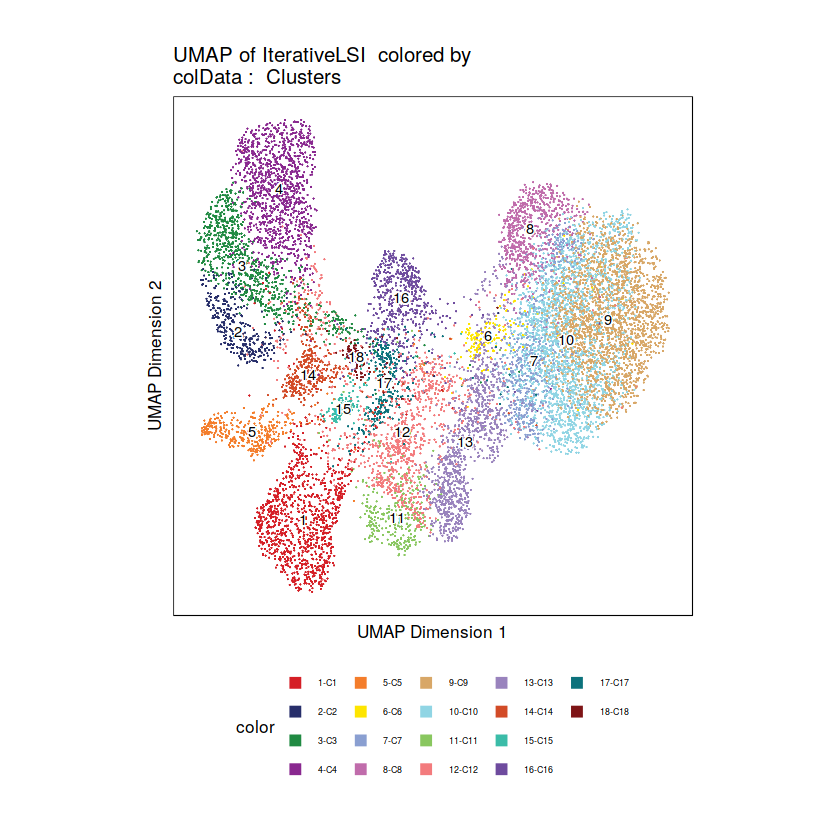

In [11]:
# - check the umap of the clustering result.
# This step is important to check the batch of the data. If the data is from different batches, 
# we recommend users to subset specific donor or tissue to generate the cell-by-peak matrix


p <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
p

## Generate cell-by-peak matrix

In [12]:
proj2 <- addGroupCoverages(ArchRProj = proj, groupBy = "Clusters")

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-1cdb032bb9681d-Date-2023-09-20_Time-19-19-30.log
If there is an issue, please report to github with logFile!

C1 (1 of 18) : CellGroups N = 2

C2 (2 of 18) : CellGroups N = 2

C3 (3 of 18) : CellGroups N = 2

C4 (4 of 18) : CellGroups N = 2

C5 (5 of 18) : CellGroups N = 2

C6 (6 of 18) : CellGroups N = 2

C7 (7 of 18) : CellGroups N = 2

C8 (8 of 18) : CellGroups N = 2

C9 (9 of 18) : CellGroups N = 2

C10 (10 of 18) : CellGroups N = 2

C11 (11 of 18) : CellGroups N = 2

C12 (12 of 18) : CellGroups N = 2

C13 (13 of 18) : CellGroups N = 2

C14 (14 of 18) : CellGroups N = 2

C15 (15 of 18) : CellGroups N = 2

C16 (16 of 18) : CellGroups N = 2

C17 (17 of 18) : CellGroups N = 2

C18 (18 of 18) : CellGroups N = 2

2023-09-20 19:19:31 : Creating Coverage Files!, 0.031 mins elapsed.

2023-09-20 19:19:31 : Batch Execution w/ safelapply!, 0.031 mins elapsed.

2023-09-20 19:24:39 : Adding Kmer Bias to Coverage Files!, 5.156 mins elapsed.

C

In [13]:
table(proj2$Clusters)


  C1  C10  C11  C12  C13  C14  C15  C16  C17  C18   C2   C3   C4   C5   C6   C7 
1081 2123  305 1052 1055  383  155  563  284   96  334  847 1196  356  157  556 
  C8   C9 
 691 2153 

In [14]:
proj2 <- addReproduciblePeakSet(
    ArchRProj = proj2, 
    groupBy = "Clusters", 
    pathToMacs2 = pathToMacs2
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-1cdb0359e50823-Date-2023-09-20_Time-19-26-18.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2023-09-20 19:26:18 : Peak Calling Parameters!, 0.003 mins elapsed.



    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1   1081        540           2   40  500   150000
C2     C2    334        334           2   40  294   150000
C3     C3    847        540           2   40  500   150000
C4     C4   1196        540           2   40  500   150000
C5     C5    356        356           2   40  316   150000
C6     C6    157        157           2   40  117    78500
C7     C7    556        540           2   40  500   150000
C8     C8    691        540           2   40  500   150000
C9     C9   2153        540           2   40  500   150000
C10   C10   2123        561           2   61  500   150000
C11   C11    305        305           2   40  265   150000
C12   C12   1052        540           2   40  500   150000
C13   C13   1055        984           2  484  500   150000
C14   C14    383        383           2   40  343   150000
C15   C15    155        155           2   40  115    77500
C16   C16    563        540           2   40  500   1500

2023-09-20 19:26:18 : Batching Peak Calls!, 0.003 mins elapsed.

2023-09-20 19:26:18 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-09-20 19:32:23 : Identifying Reproducible Peaks!, 6.082 mins elapsed.

2023-09-20 19:32:35 : Creating Union Peak Set!, 6.282 mins elapsed.

Converged after 7 iterations!

Plotting Ggplot!

2023-09-20 19:32:43 : Finished Creating Union Peak Set (246132)!, 6.414 mins elapsed.



In [15]:
proj3 <- addPeakMatrix(proj2)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-1cdb0372812190-Date-2023-09-20_Time-19-32-43.log
If there is an issue, please report to github with logFile!

2023-09-20 19:32:43 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-1cdb0372812190-Date-2023-09-20_Time-19-32-43.log



In [16]:
PeakMatrix=getMatrixFromProject(
  ArchRProj = proj3,
  useMatrix = "PeakMatrix",
  useSeqnames = NULL,
  verbose = TRUE,
  binarize = FALSE,
  threads = getArchRThreads(),
  logFile = createLogFile("getMatrixFromProject")
)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-1cdb036f0ac7cc-Date-2023-09-20_Time-19-35-39.log
If there is an issue, please report to github with logFile!

2023-09-20 19:36:46 : Organizing colData, 1.119 mins elapsed.

2023-09-20 19:36:46 : Organizing rowData, 1.119 mins elapsed.

2023-09-20 19:36:46 : Organizing rowRanges, 1.12 mins elapsed.

2023-09-20 19:36:46 : Organizing Assays (1 of 1), 1.12 mins elapsed.

2023-09-20 19:36:49 : Constructing SummarizedExperiment, 1.169 mins elapsed.

2023-09-20 19:36:50 : Finished Matrix Creation, 1.186 mins elapsed.



In [17]:
pm_peak=getPeakSet(proj3)
pm_barcode=colData(PeakMatrix)
pm_matrix=assay(PeakMatrix)

In [18]:
dim(pm_matrix)

[1] 246132  13387

## save the results

In [20]:
# - save the cell-by-peak matrix generated by ArchR
write.csv(pm_peak,paste0(dir_,'/',"pm_peak.csv"),row.names=TRUE)
write.csv(pm_barcode,paste0(dir_,'/',"pm_barcode.csv"),row.names=TRUE)
writeMM(as(pm_matrix, "dgTMatrix"), paste0(dir_,'/',"pm_matrix.mtx"))

NULL